<a href="https://colab.research.google.com/github/jjyjung/ai/blob/gh-pages/%EB%B0%80%EB%A7%81%ED%97%A4%EB%93%9C_%EB%AA%A8%EB%8B%88%ED%84%B0%EB%A7%81_%EC%8B%A4%EC%8A%B5_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AI를 이용한 밀링헤드 모니터링 실습**💡

*   **목적** : 머신비전을 이용하여 밀링헤드의 부러진 insert를 검출하는 실습 예제

*   **알고리즘** : 객체 검출(Object Detection) 알고리즘 YOLOv5 (출처: https://pytorch.org/hub/ultralytics_yolov5/)

*   **데이터셋** : Edge milling heads Dataset (출처: https://gvis.unileon.es/dataset/edge-milling-heads-dataset-144-images/)

 *해당 데이터셋은 현재 연구목적으로 배포자의 요청 하에만 이용할 수 있으므로 무단 배포 금지*


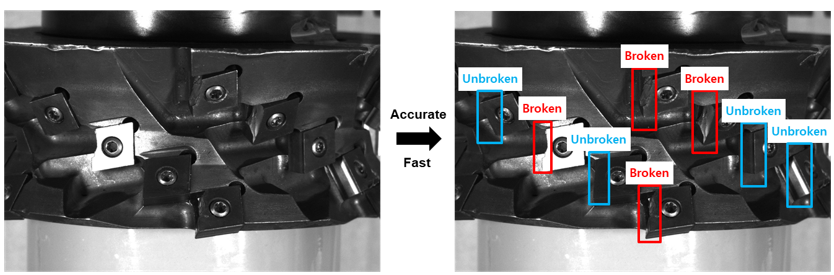



 ## **0.  AI를 이용한 이미지 처리**

* AI 기반의 영상처리 문제는 크게 아래와 같이 구분할 수 있음
  * **분류 (Classification)** : 이미지가 어떤 카테고리에 속하는지를 예측
  * **지역화 (Localization)** : 이미지 내 특정 객체(Object)의 위치에 대한 박스를 탐색
  * **검출 (Detection)** : 이미지 내 모든 객체들에 대한 bounding box를 탐색
  * **분할 (Segmentation)** : 이미지 내 객체의 경계를 구분
* 본 실습자료를 밀링헤드 파손 여부를 모니터링하기 위하여, 객체 검출(Object Detection) AI 기술을 활용하는 예시임

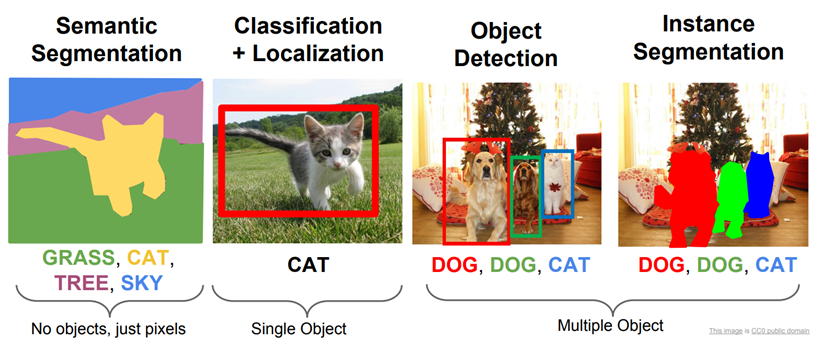

(출처: Standford University, cs231n)

### 런타임 유형 변경 (CPU -> GPU)
 * 딥러닝을 이용한 이미지 학습에는 CPU보다 GPU 연산이 속도가 빠름
 * Colab의 런타임 유형은 CPU가 기본으로 되어있어서 GPU로 변경하는 것이 좋음
 * 메뉴 > 런타임 > 런타임유형변경에서 GPU로 선택을 변경할 수 있음


 ## **1. 데이터 준비**
 ### 1.1. 데이터 소개

* 6개의 밀링헤드에 대하여 각각 24장의 이미지를 촬영하여, 총 120장의 이미지를 저장하고 있음
* 가공 중 밀링헤드의 정지 시점에 약간씩 회전하면서 촬영한 정지영상을 사용하여 파손 여부를 진단함
* 하나의 밀링헤드에는 30개의 insert가 장착되어 있으며, 이 insert 중에서 사용 중에 파손된 insert를 탐지하는 것을 목표로 함


 ## **1.2. 데이터 라벨링**

*   이미지 학습을 위하여 데이터의 분류값을 지정하는 것을 데이터 라벨링(data labeling)이라고 하며, 이미지 데이터에 대해서도 사전에 수작업으로 이미지의 어떤 부분에 어떤 객체가 존재하는지 지정해야하며 이를 데이터 라벨링 또는 데이터 어노테이션(annotation)이라고 함
*   정상 insert는 'unbroken', 깨진 insert는 'broken'으로 라벨링
*   라벨링 완료 후, YOLO format으로 export

## **2. YOLOv5 코드 다운로드**
* 아래 코드를 실행하여 github에 공개되어 있은 YOLOv5 소스코드들을 Colab으로 불러올 수 있음
* Colab 화면 왼쪽 메뉴의 Colab 저장소에 sample_data 폴더 외에 YOLOv5 폴더가 새롭게 생성되고 그 안에 YOLOv5 소스코드가 저장됨


In [ ]:
!git clone https://github.com/ultralytics/yolov5

## **3. 데이터 업로드**
* 데이터 업로드를 위해 Colab에 폴더를 생성합니다.
* 아래 코드를 실행하면, Colab 폴더에 이미지 파일 및 라벨링 파일을 업로드할 수 있는 폴더가 자동생성 됩니다.


In [ ]:
!mkdir -p datasets/images/{raw,train,validation,test} datasets/labels/{raw,train,validation,test}

In [ ]:
# !rm /content/datasets/images/train/*
# !rm -rf /content/datasets/labels/train/

## **[중요] 이미지 파일 및 라벨링 파일 업로드 하기**
* <a href=https://drive.google.com/drive/folders/16Hban4m7S7tPgPiMA-fevjNThS_rV2Ru target=new>공유 클라우드</a>에 방문하여 **MillingHead.zip** 파일을 다운로드 받으시오. (**항목을 오른쪽 클릭하여 다운로드 클릭!**)
* **MillingHead.zip** 파일을 풀면 datasets 폴더가 있습니다. 
* datasets 내의 아래 파일들을 Colab 왼쪽에 해당 폴더에 업로드 하세요. (drag & drop 하면 됩니다.)

 * datasets/images/raw -> raw 이미지 데이터(120장) -> Colab의 동일 폴더에 업로드<br>
 * datasets/labels/raw -> raw 레이블 데이터(120개) -> Colab의 동일 폴더에 업로드

 * datasets/images/test -> test 이미지 데이터(24장) -> Colab의 동일 폴더에 업로드<br>
 * datasets/labels/test -> test 레이블 데이터(24개) -> Colab의 동일 폴더에 업로드

In [ ]:
# 현재 작업 경로 확인
!pwd

## **4. 데이터 나누기 (Training set, Validation set, Test set)**

*   총 6개의 밀링헤드에 대하여 총 144장의 이미지 존재 (24장 * 6개 = 144장)

*   1~5번 밀링헤드 이미지 : Training set 및 Validation set으로 사용
*   6번 이미지 : Test set으로 사용

⭐ Training, Validation set 나눌 때, 이미지 내 unbroken insert 개수와 broken insert 개수 비율을 유사하게 나눔 (층화추출)

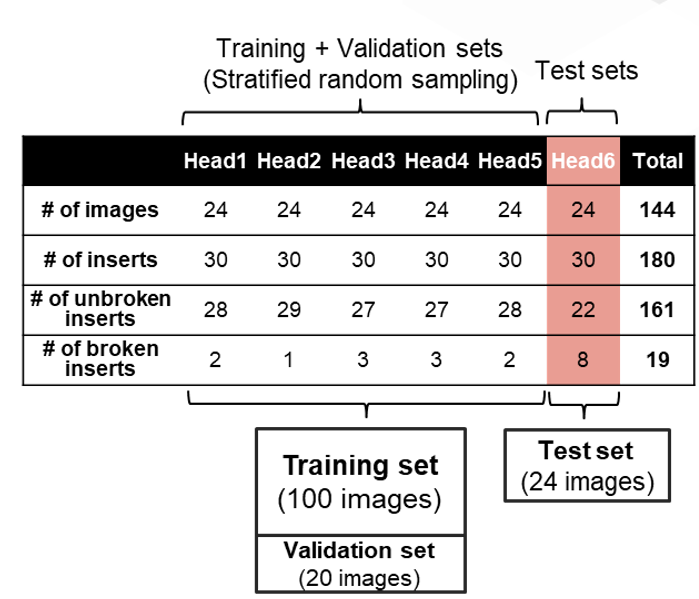

In [ ]:
import numpy as np
import shutil
import os
import datetime

now = datetime.datetime.now()

def load_file(path):
    file_list = os.listdir(path)
    return file_list


# 클래스 개수 추출
def get_class_num(path):
    txt_file_list = load_file(path)
    txt_file_list = [file for file in txt_file_list if file.endswith(".txt")]

    class_array = np.zeros((len(txt_file_list), 3), dtype='int')
    for i, file_name in enumerate(txt_file_list):
        with open(path + '/' + file_name, 'r') as f:
            lines = f.readlines()
            unbroken = 0
            broken = 0
            for line in lines:
                if line[0] == '0':
                    unbroken += 1
                else:
                    broken += 1
        class_array[i] = [int(file_name[-8:-4]), unbroken, broken]
    return class_array


def split_in_strat(class_array):
    unbroken_idx, = np.where(class_array[:, 2] == 0)
    broken_idx, = np.where(class_array[:, 2] != 0)

    unbroken = class_array[unbroken_idx]
    broken = class_array[broken_idx]

    np.random.seed(42)
    np.random.shuffle(unbroken)
    np.random.shuffle(broken)

    print('0 broken distribution')
    print(len(unbroken))

    unique, counts = np.unique(broken[:, 2], return_counts=True)
    di = dict(zip(unique, counts))
    print('broken distribution')
    print(di)

    broken_one_idx, = np.where(broken[:, 2] == 1)
    broken_two_idx, = np.where(broken[:, 2] == 2)
    broken_three_idx, = np.where(broken[:, 2] == 3)
    broken_four_idx, = np.where(broken[:, 2] == 4)

    print('broken_three_idx', len(broken_three_idx))
    print('broken_four_idx', len(broken_four_idx))

    unbroken_img_number_trn = unbroken[:57]
    broken_img_number_trn = np.concatenate((broken[broken_one_idx][:27], broken[broken_two_idx][:14],
                                            broken[broken_three_idx][:2], broken[broken_four_idx][:5]), axis=0)

    unbroken_img_number_val = unbroken[57:]
    broken_img_number_val = np.concatenate((broken[broken_one_idx][27:], broken[broken_two_idx][14:],
                                            broken[broken_three_idx][2:], broken[broken_four_idx][5:]), axis=0)

    trn_img_number = np.sort(np.concatenate((unbroken_img_number_trn[:, 0], broken_img_number_trn[:, 0])))
    val_img_number = np.sort(np.concatenate((unbroken_img_number_val[:, 0], broken_img_number_val[:, 0])))

    print((np.sum(unbroken_img_number_trn[:, 1]) + np.sum(broken_img_number_trn[:, 1])) / np.sum(broken_img_number_trn[:, 2]))
    print((np.sum(unbroken_img_number_val[:, 1]) + np.sum(broken_img_number_val[:, 1])) / np.sum(broken_img_number_val[:, 2]))

    print('trn_img_number', len(trn_img_number))
    print('val_img_number', len(val_img_number))

    return trn_img_number, val_img_number


# Training set 만들기
def make_trn_dataset(img_number):
    trn_txt_file_name = '%s%s%s.%s' % ('./', 'trn', '_filepath', 'txt')
    with open(trn_txt_file_name, 'a') as f: #이미지파일 경로 텍스트 파일 작성
        # 이미지 파일 옮기기
        os.chdir('/content/datasets/images/raw')
        img_file_list = load_file('./')
        img_file_list = [file for file in img_file_list if file.endswith(".bmp")]
        for file_name in img_file_list:
            img_num = int(file_name[8:12])
            if img_num in img_number:
                shutil.copy(file_name, '/content/datasets/images/train')
                content = '/content/datasets/images/train' + '/' + file_name
                # content_rp = content.replace('\\', '/')
                f.write(content + '\n')

        # bounding box 좌표 텍스트 파일 옮기기
        os.chdir('/content/datasets/labels/raw')
        txt_file_list = load_file('./')
        txt_file_list = [file for file in txt_file_list if file.endswith(".txt")]
        for file_name in txt_file_list:
            txt_num = int(file_name[8:12])
            if txt_num in img_number:
                shutil.copy(file_name, '/content/datasets/labels/train')


# Validation set 만들기
def make_val_dataset(img_number):
    os.chdir('/content/datasets/images/raw')
    val_txt_file_name = '%s%s%s.%s' % ('./', 'val', '_filepath', 'txt')
    with open(val_txt_file_name, 'a') as f: #이미지 파일 경로 텍스트 파일 작성
        # 이미지 파일 옮기기
        os.chdir('/content/datasets/images/raw')
        img_file_list = load_file('./')
        img_file_list = [file for file in img_file_list if file.endswith(".bmp")]
        for file_name in img_file_list:
            img_num = int(file_name[8:12])
            if img_num in img_number:
                shutil.copy(file_name, '/content/datasets/images/validation')
                content = '/content/datasets/images/validation' + '/' + file_name
                # content_rp = content.replace('\\', '/')
                f.write(content + '\n')

        # bounding box 좌표 텍스트 파일 옮기기
        os.chdir('/content/datasets/labels/raw')
        txt_file_list = load_file('./')
        txt_file_list = [file for file in txt_file_list if file.endswith(".txt")]
        for file_name in txt_file_list:
            txt_num = int(file_name[8:12])
            if txt_num in img_number:
                shutil.copy(file_name, '/content/datasets/labels/validation')


if __name__ == "__main__":
    class_array = get_class_num('/content/datasets/labels/raw')
    # print(class_array)
    trn_img_number, val_img_number = split_in_strat(class_array)
    print(trn_img_number)
    print(val_img_number)

    make_trn_dataset(trn_img_number)
    make_val_dataset(val_img_number)


## **5. 모델 훈련하기**



### **5.1 파일생성**

## **[중요] 설정 파일(.yaml) 업로드 하기**
*   **MillingHead.zip** 파일을 풀면 millinghead.yaml 파일이 있습니다.
*   .yaml 파일에는 아래와 같이 데이터셋 경로 및 클래스 정보가 기재되어 있습니다.
*   millinghead.yaml 파일을 /yolov5/data에 업로드 시키시오.

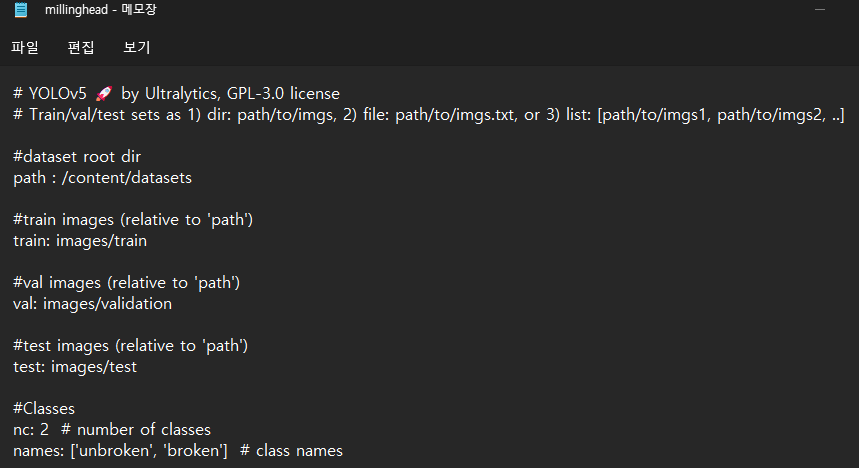

### **5.2 하이퍼파라미터 튜닝**

*   모델 훈련에 사용되는 학습률, IoU 임계값 등을 설정함
*   yolov5-master/data/hyps 경로에 파라미터 설정 파일 존재
*   데이터 augmentation
  - translate (이미지 이동)
  - shear (기울임)
  - rotation (회전)
  - fliplr (좌우반전): 0.5 -> 0.0 (probability)
  - flipup (상하반전): 0.0 -> 0.5 (probability)














### **5.3 모델 훈련 실행**

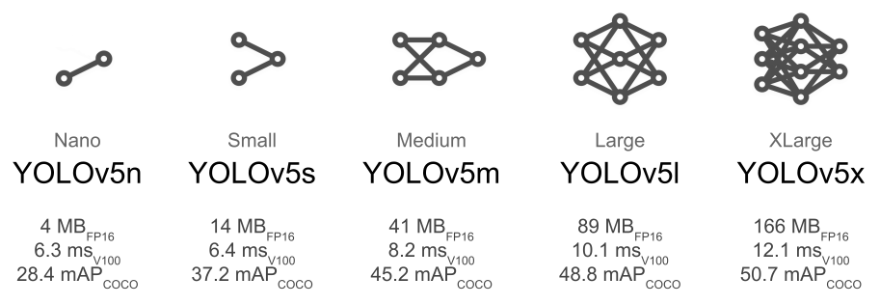
*   **--img** : 훈련 이미지 크기
*   **--batch** : 배치사이즈 크기
*   **--epochs** : 훈련 에포크 횟수
*   **--patience** : 훈련 조기종료 임계값
*   **--data** : .yaml 파일 경로
*   **--weights** : pretrained 모델 가중치 



> 파라미터 관련 참고: https://github.com/ultralytics/yolov5/blob/master/train.py (474~517 lines)



In [ ]:
!python /content/yolov5/train.py --data millinghead.yaml --img 640 --batch 16 --epochs 5  --weights yolov5m.pt

## **6. 모델 테스트하기**




# **[중요] 사전에 학습된 모형(best_admin.pt) 업로드 하기**
*   시간 관계상 미리 학습된 모델(best_admin.pt)를 이용하여 모델을 테스트해봅시다.
*   **MillingHead.zip** 파일을 풀면 밀링헤드 모니터링에 대하여 학습되어 있는 best_admin.pt 파일이 있습니다.
*   best_admin.pt 파일을 Colab의 아래 경로(/yolov5/runs/train/exp2/weights/)에 업로드 하시오.

In [ ]:
!python /content/yolov5/val.py --weights '/content/yolov5/runs/train/exp2/weights/best_admin.pt' --data millinghead.yaml --img 640 --conf-thres 0.5 --batch-size 1 --task 'test'

### **6.1 모델 성능지표 추출**
*   --weights : 훈련된 모델 가중치 경로
*   --conf-thres : confidence 임계값
*   --batch-size : 테스트 시 배치사이즈

테스트 이미지 데이터로 모델 성능 확인하기

### **6.2 예측 결과 이미지 추출** 

In [ ]:
import os
import torch

# 훈련된 모델 가중치 저장 경로
model_path = '/content/yolov5/runs/train/exp2/weights/best_admin.pt'

# Model
model = torch.hub.load('ultralytics/yolov5', 'custom', model_path)

# 테스트 이미지 목록 불러오기
os.chdir('/content/datasets/images/test')
test_img_file_list = os.listdir('/content/datasets/images/test')
test_img_file_list = [file for file in test_img_file_list if file.endswith(".bmp")]
print(test_img_file_list)

# Inference
results = model(test_img_file_list)

# Results
results.save() # or .print(), .show(), .save(), .crop(), .pandas(), etc.

# 아래 경로에 저장됨: /content/datasets/images/test/runs/detect/exp

In [ ]:
!zip exp.zip -r /content/datasets/images/test/runs/detect/exp

In [ ]:
from google.colab import files

files.download('/content/datasets/images/test/exp.zip')